# 0. Loading packages

Uncomment cell below if not all necessary packages are installed

In [11]:
# Install necessary packages
# %pip install numpy
# %pip install matplotlib
# %pip install pandas
# %pip install seaborn
# %pip install scikit-learn
# %pip install missingno
# %pip install imblearn
# %pip install xgboost

In [12]:
import warnings
warnings.filterwarnings('ignore')

import functions as fc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.fft import fft, ifft
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Loading data

In [13]:
train_data = pd.read_csv('Datasets/train.csv')
test_data = pd.read_csv('Datasets/test.csv')

test_data_pred_col = test_data['date_hour']

# 2. Inspecting data

## 2.1 Showing datasets

In [14]:
train_data.head()

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1


In [15]:
test_data.head()

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed
0,2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000
1,2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000
2,2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000
3,2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343
4,2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896


In [25]:
train_data.describe()

,holiday,weathersit,temp,atemp,hum,windspeed,cnt
count,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000
mean,0.028671,1.415580,0.504745,0.482608,0.624756,0.190310,190.477009
std,0.166885,0.637298,0.192369,0.171557,0.193227,0.121915,182.026755
min,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,41.000000
50%,0.000000,1.000000,0.520000,0.500000,0.620000,0.194000,143.000000
75%,0.000000,2.000000,0.660000,0.621200,0.780000,0.253700,282.000000
max,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


## 2.2 Inspecting missing data

In [16]:
dv_train = fc.DataVisualizer(train_data)
dv_test = fc.DataVisualizer(test_data)

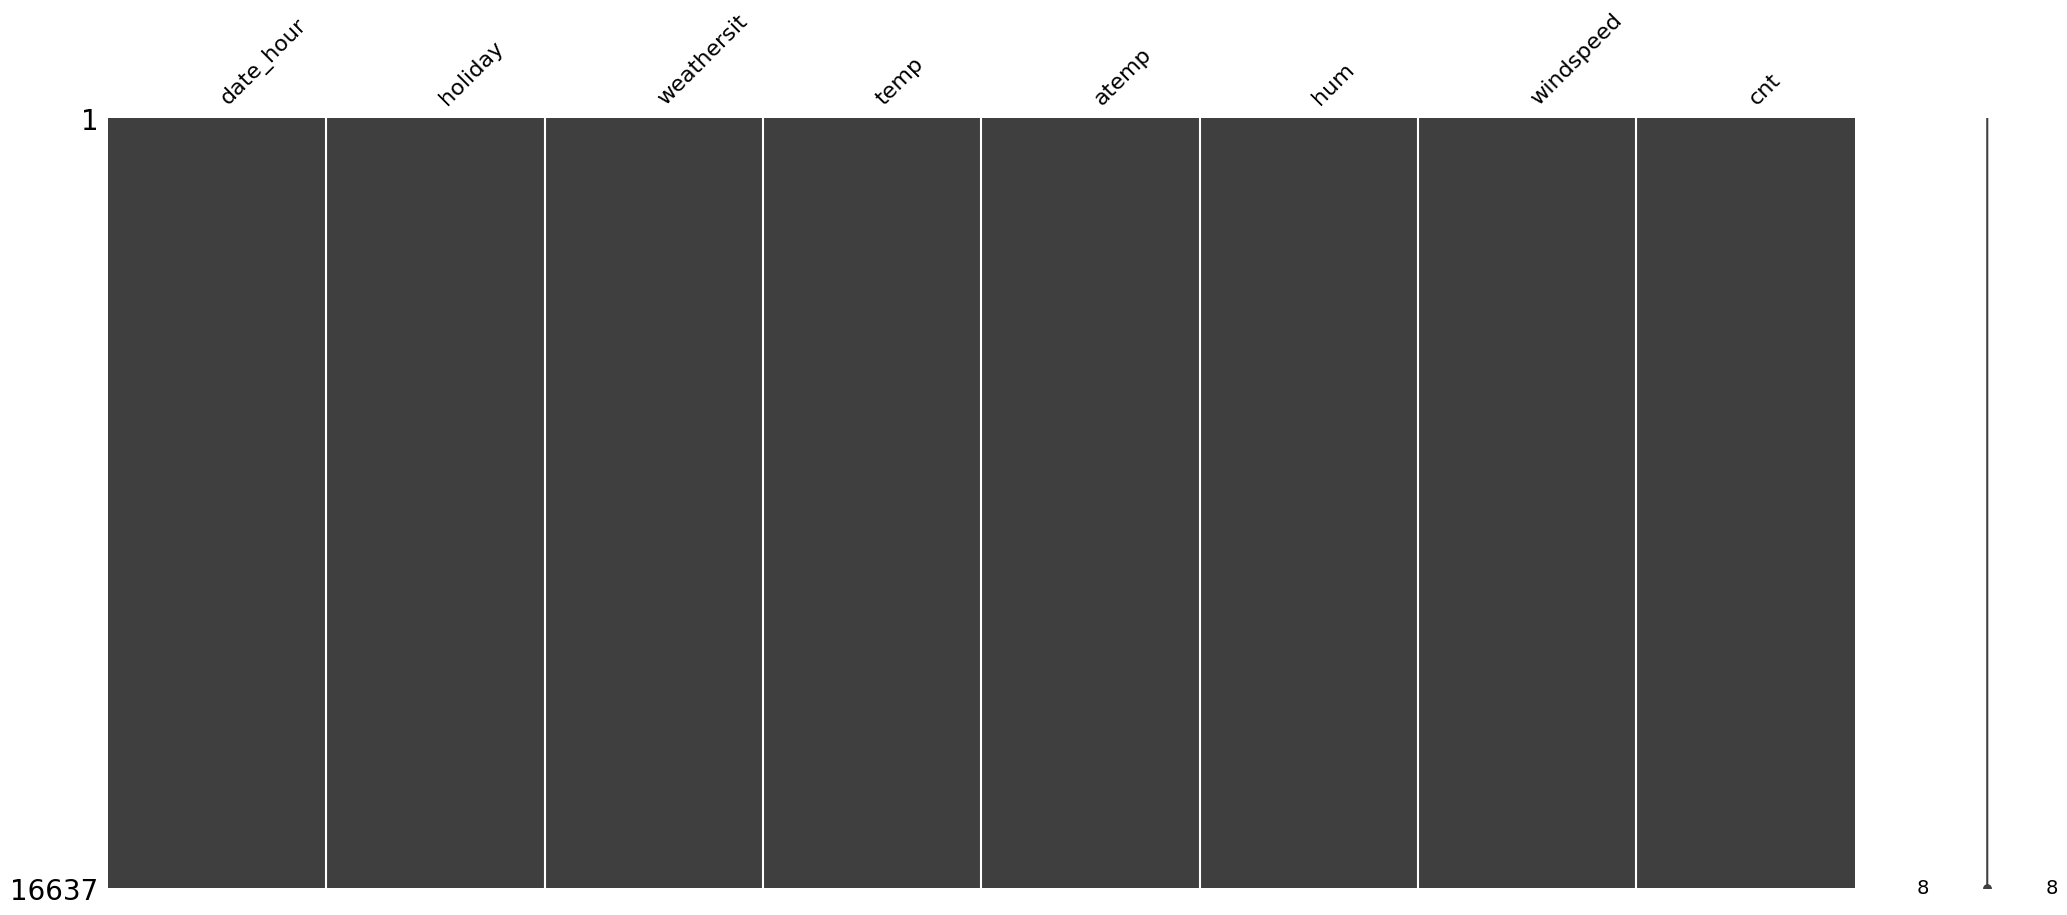

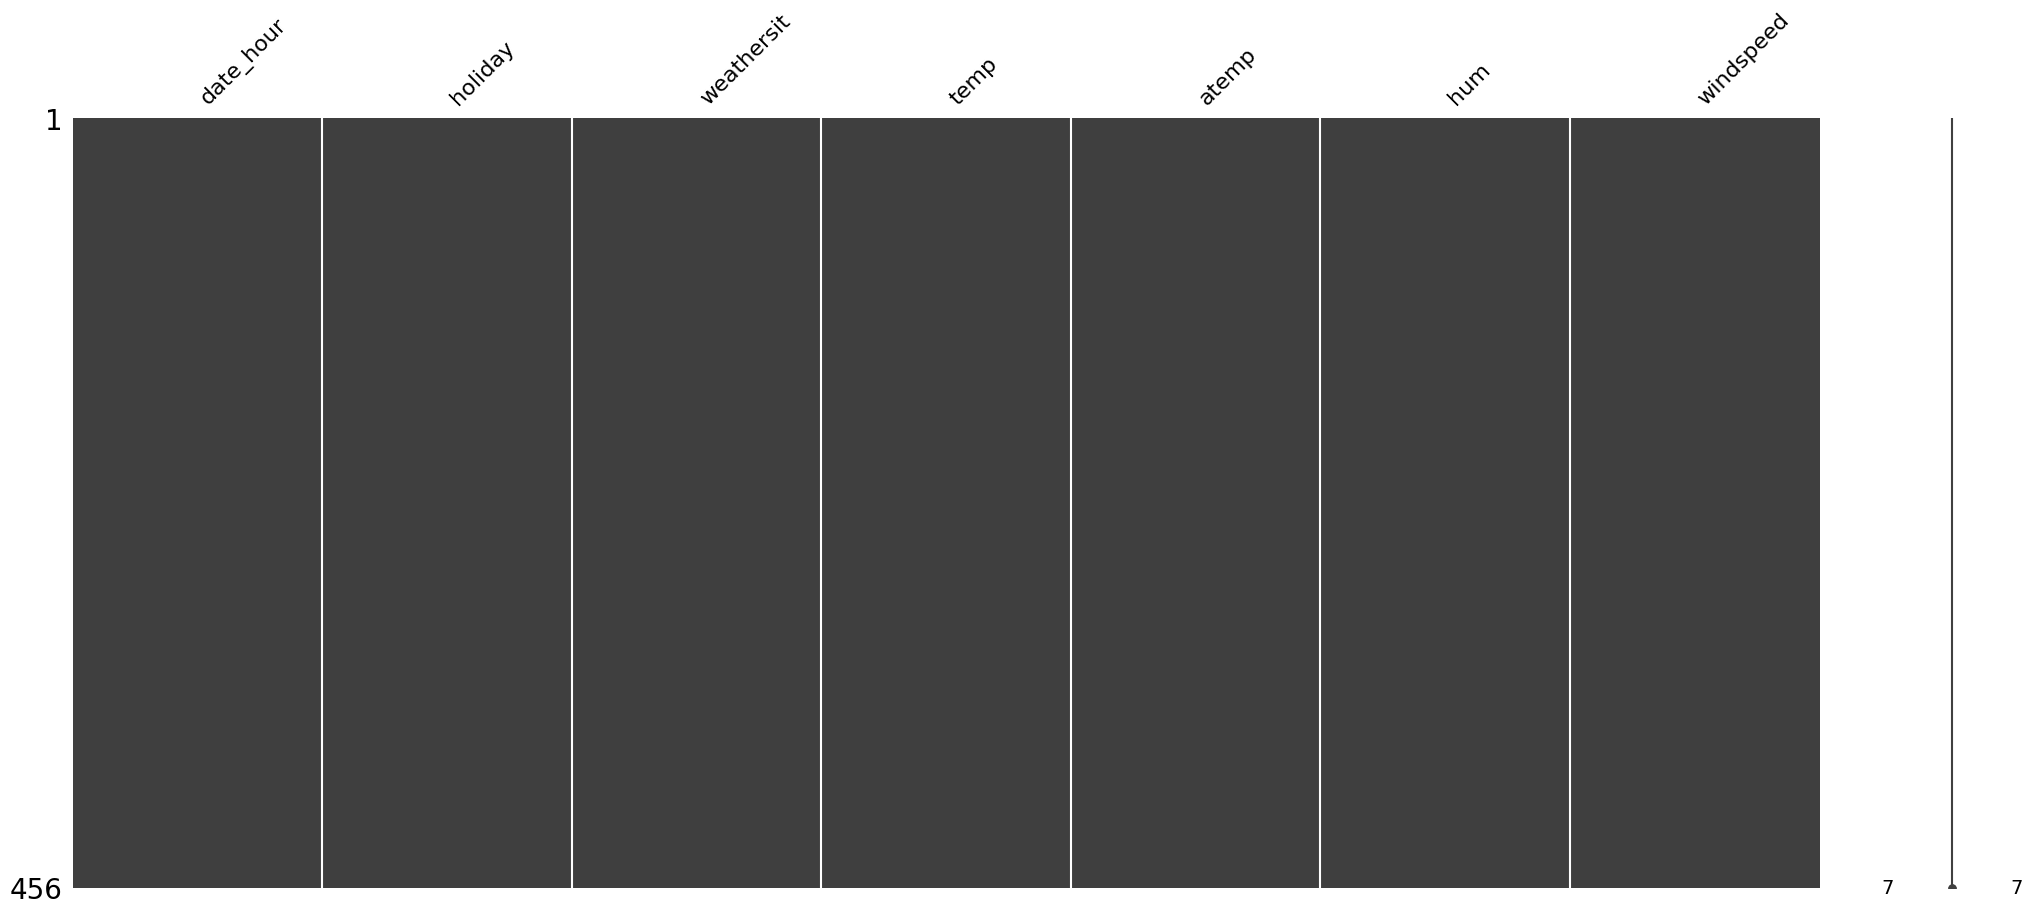

(None, None)

In [17]:
dv_train.plot_missing_values(), dv_test.plot_missing_values()

In [18]:
train_data.isna().sum(), test_data.isna().sum()

(date_hour     0
 holiday       0
 weathersit    0
 temp          0
 atemp         0
 hum           0
 windspeed     0
 cnt           0
 dtype: int64,
 date_hour     0
 holiday       0
 weathersit    0
 temp          0
 atemp         0
 hum           0
 windspeed     0
 dtype: int64)

Neither datasets (`train_data` and `test_data`) contains missing data.

## 2.3 Inspecting individual columns

In [19]:
cols = ['holiday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']

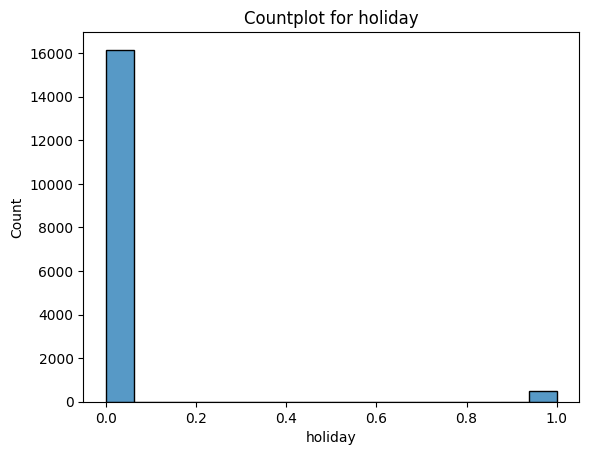

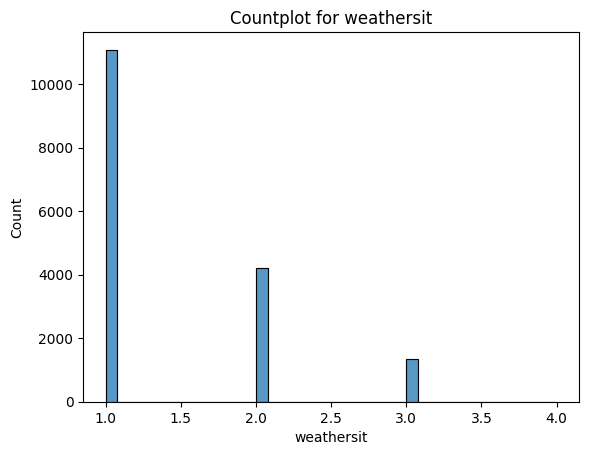

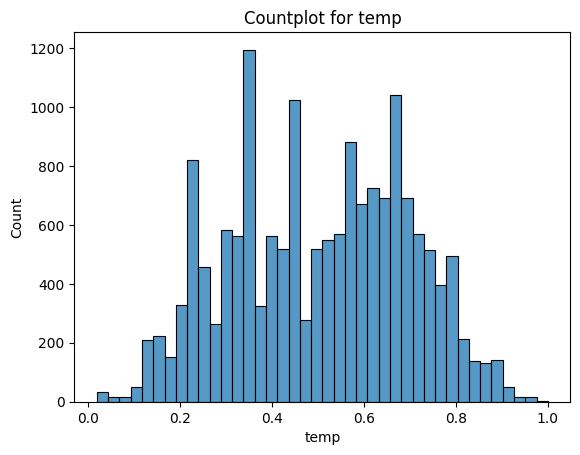

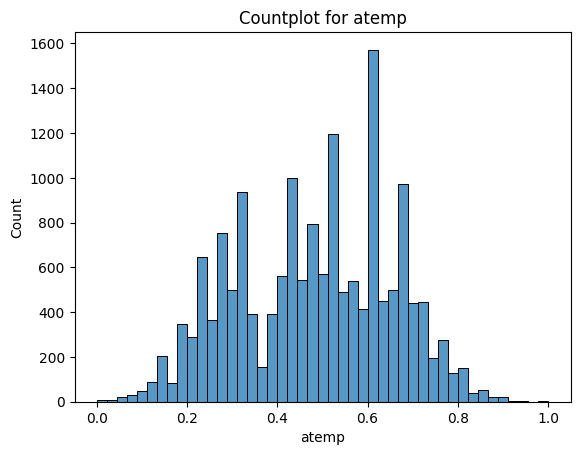

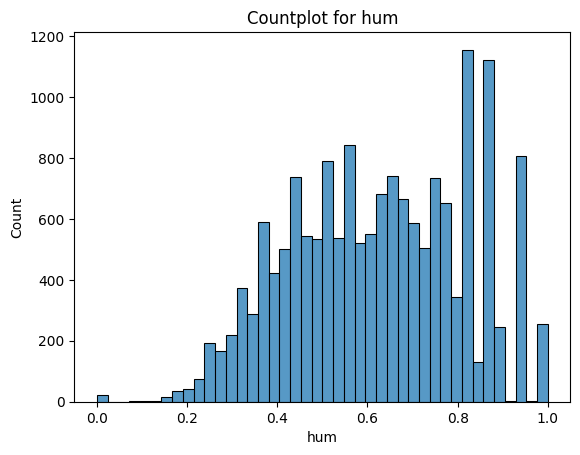

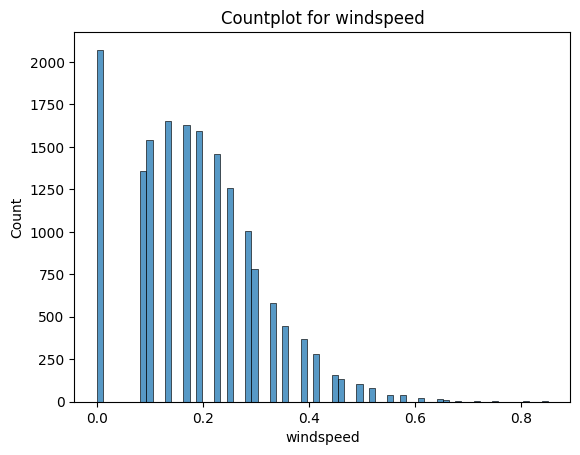

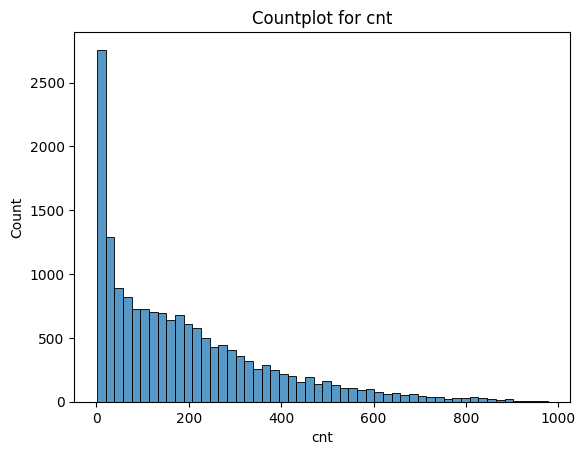

In [20]:
dv_train.plot_distribution(cols, 'train_data')

Add explanation of what is visible in the histplots

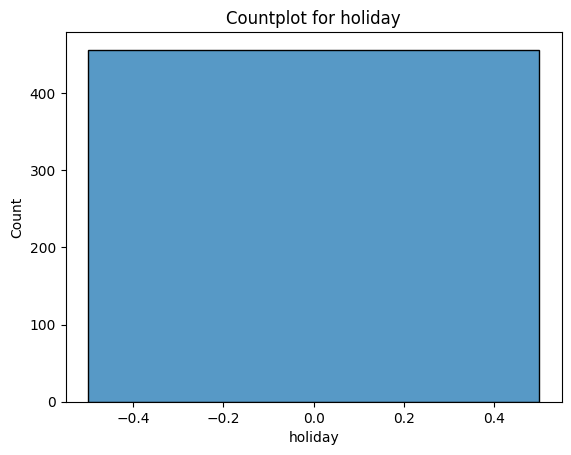

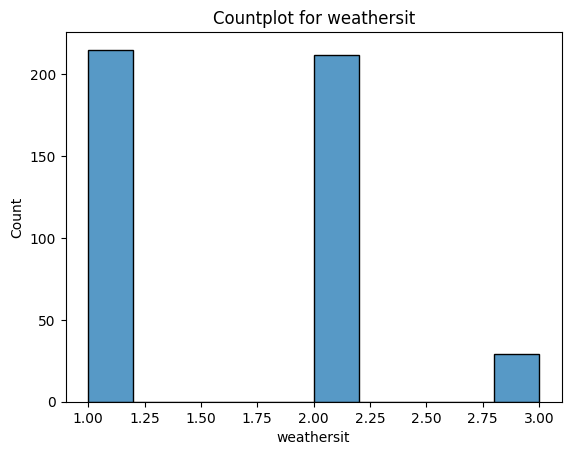

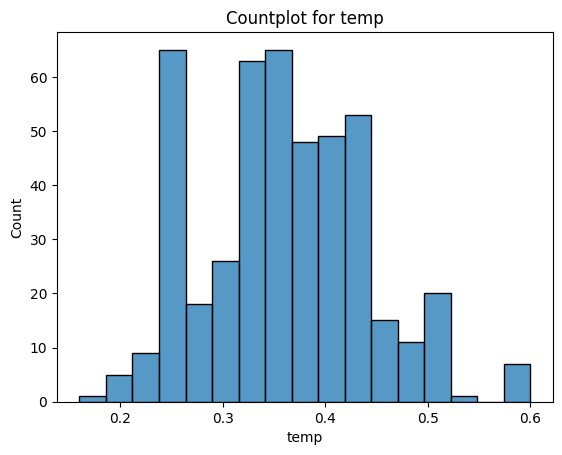

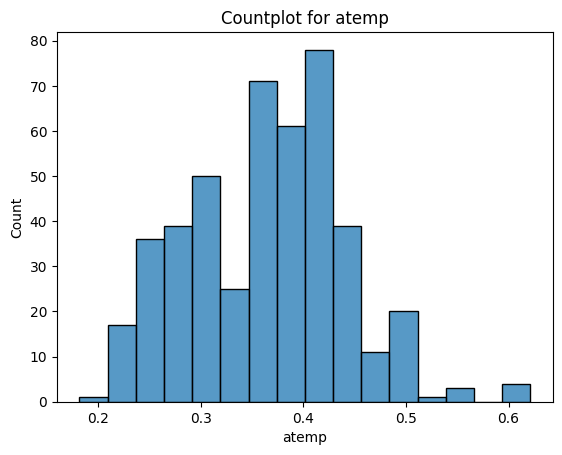

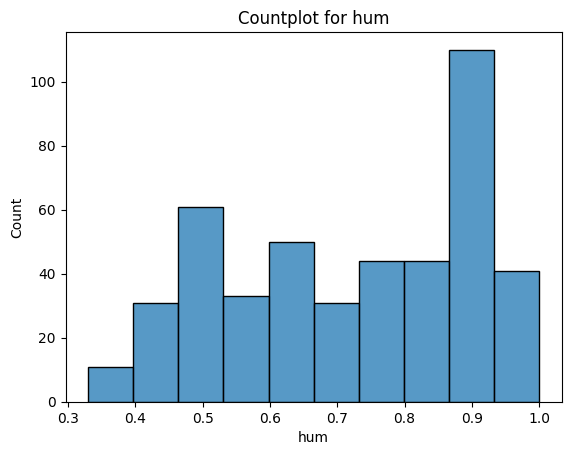

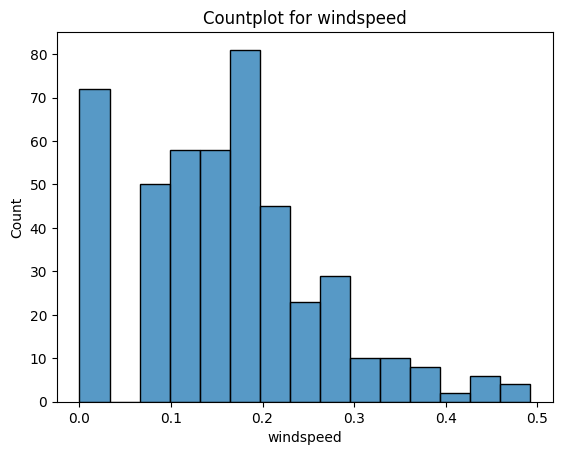

cnt not in the dataset


In [21]:
dv_test.plot_distribution(cols, 'test_data')

Add explanation of what is visible in the histplots

## 2.4 Datatypes

In [22]:
train_data.info(), test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_hour   16637 non-null  object 
 1   holiday     16637 non-null  int64  
 2   weathersit  16637 non-null  int64  
 3   temp        16637 non-null  float64
 4   atemp       16637 non-null  float64
 5   hum         16637 non-null  float64
 6   windspeed   16637 non-null  float64
 7   cnt         16637 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 1.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_hour   456 non-null    object 
 1   holiday     456 non-null    int64  
 2   weathersit  456 non-null    int64  
 3   temp        456 non-null    float64
 4   atemp       456 non-null    float64
 5   hum         456 non-null

(None, None)

The columns in the dataset are predominantly of data types `int` or `float`, except for the `date_hour` column, which is of type `object`. This column will need to be converted to the `datetime` format for further analysis.

## 2.5 Relationships between variables

In [23]:
methods = ['pearson', 'kendall', 'spearman']

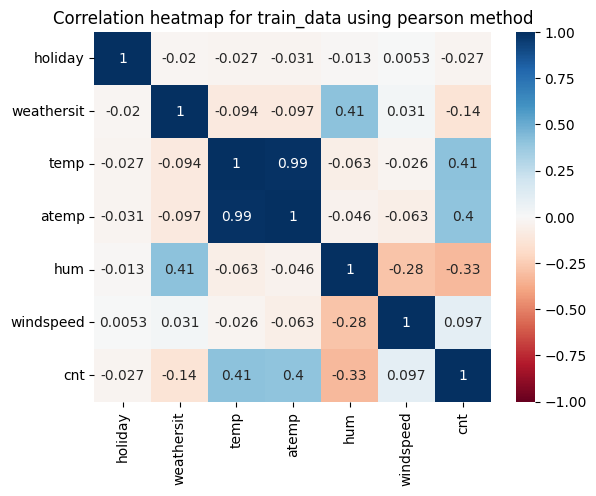

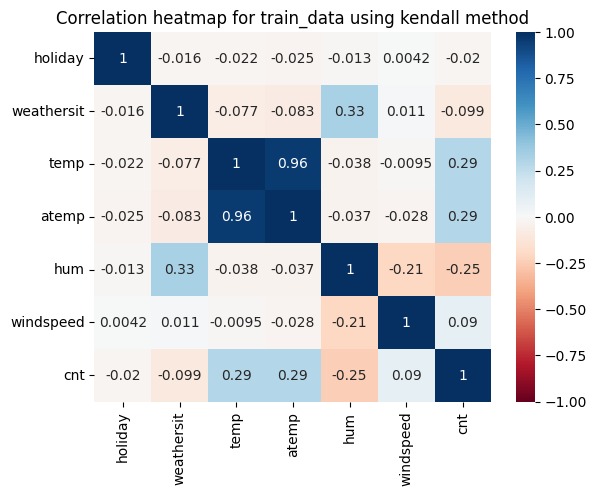

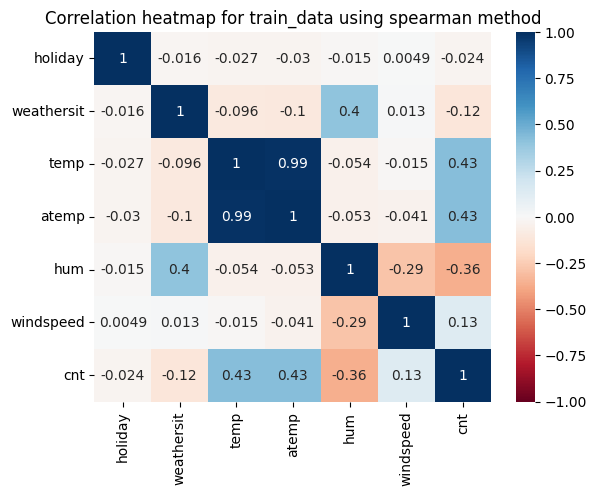

In [24]:
for method in methods:
    dv_train.plot_correlation('train_data', method)

Add explanation of what is visible in the corrplots

## 2.6 Minimum requirements for Machine Learning with Scikit Learn